## Drug Discovery -- Mechanism of Action

### Gene Expression

Gene expression is the process by which information from a gene is used to synthesize a functional gene product, i.e. a protein. These proteins ultimately create a person's phenotype, which is the observable traits that are expressed through someone's genotype. With the correct molecular formulation, genetic transcription pathways can be inhibited or catalyzed by a given medication, and by manipulating these pathways humans are able to alter the chemistry within our bodies and fight cancer or treat hypertension for example.

Recording and cataloging gene expression data is especially important for pharmaceutical development since the goal of any medication is to modulate a transcriptional pathway, and through repetition or trials, trends may be observed to determine its safety or lack thereof within an in vitro and then in-human setting.   

### Cell Viability 

Cell viability is a measurement of the total live, healthy cells within a given sample. Assays are used to quantify factors such as metabolic activity, presence of ATP and cell proliferation, and also the toxicity or markers signifying the death of a cell. When introducing investigational compounds within an in-vitro environment, possessing the ability to quantify the enhancement or inhibition of certain cellular processes becomes extremely important because these metrics are used to scale the effectiveness and/or harmfulness of the compound within the human body. Understanding how well a compound is absorbed may be of particular concern to clinical researchers, because a negative downstream effect could be blood toxicity due to compounds that cannot be metabolized, or a positive downstream effect  from proper absorption could be the proliferation of healthy cells vs. harmful cells.  

For example, a PD-L1 checkpoint inhibitor is a class of drugs meant to interupt the binding of PD-L1 to a PD-1 receptor. Cancer cells express the PD-L1 protein and they use it to bind to an immune cell's PD-1 receptor, thus helping the cancer cells avoid being detected as a foreign/threatening object. So PD-L1 receptors act as an inhibiting force, preventing the binding of the molecules and leaving the cancer cells open to immune system eradication.  

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.multioutput import ClassifierChain

In [2]:
test_features = pd.read_csv('kaggle_data/test_features.csv')
train_features = pd.read_csv('kaggle_data/train_features.csv')
tt_nonscored = pd.read_csv('kaggle_data/train_targets_nonscored.csv')
tt_scored = pd.read_csv('kaggle_data/train_targets_scored.csv')

In [3]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
# Find total unique datatypes

train_features.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [5]:
dfs = [test_features, train_features]

In [6]:
# Drop 'sig_id' column from features dataframes, and convert strings and objects to integer values


def cleaner(df):
    df['cp_type'] = df['cp_type'].map({'ctl_vehicle': 0, 'trt_cp': 1})
    df['cp_time'] = df['cp_time'].map({24: 1, 48: 2, 72: 3})
    df['cp_dose'] = df['cp_dose'].map({'D1': 0 , 'D2': 1})
    return df

def col_drop(df):
    df = df.drop(columns=['sig_id'], axis=1, inplace=True)
    return df


for df in dfs:
    cleaner(df)
    col_drop(df)
    

In [7]:
keep_idx_test = test_features[test_features.cp_type != 0].index
keep_idx_train = train_features[train_features.cp_type != 0].index

tt_scored = tt_scored.drop('sig_id',1)

train_features = train_features.loc[keep_idx_train]
tt_scored = tt_scored.loc[keep_idx_train]




In [8]:
train_features.head()

# Key:
# ['cp_type'] = whether data is from control or active groups
#     0 = control
#     1 = active
# ['cp_time'] = treatment duration time
#     1 = 24hrs
#     2 = 48hrs
#     3 = 72hrs
# ['cp_dose'] = treatment strength
#     0 = low
#     1 = high 

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,1,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,1,3,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,2,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,2,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,1,3,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [9]:
test_features

# Key:
# ['cp_type'] = whether data is from control or active groups
#     0 = control
#     1 = active
# ['cp_time'] = treatment duration time
#     1 = 24hrs
#     2 = 48hrs
#     3 = 72hrs
# ['cp_dose'] = treatment strength
#     0 = low
#     1 = high

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,1,0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,1,3,0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,0,1,0,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,1,1,1,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,1,2,0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,1,1,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,...,-1.1790,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600
3978,1,1,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,-0.7437,...,0.0210,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934
3979,1,3,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,-0.0166,...,0.4418,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504
3980,1,2,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,-0.3611,...,0.3079,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484


In [10]:
# create column list for both DataFrames, as well as separate DataFrames for Gene Expression columns
# and Cell Viability columns

g_cols = [col for col in train_features if 'g-' in col]
c_cols = [col for col in train_features if 'c-' in col]

gene_df = train_features.loc[:, 'g-0':'g-771']
cell_df = train_features.loc[:, 'c-0':]
    

The column with the most identical expression values is:  g-104 with 4420 identical expression values, at 0.0 level of interactivity.
The column with the least identical expression values is:  g-175 with 9 identical expression values, at 0.0 level of interactivity.


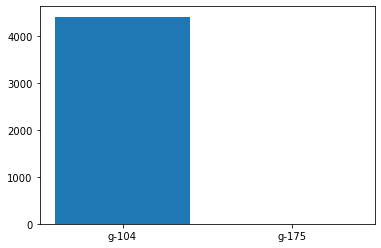

The column with the most identical expression values is:  c-93 with 465 identical expression values, at -10.0 level of interactivity.
The column with the least identical expression values is:  c-50 with 20 identical expression values, at -10.0 level of interactivity.


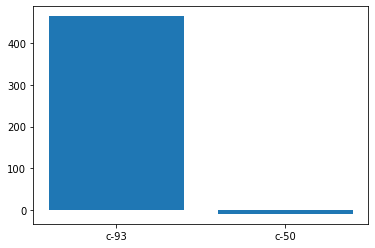

In [11]:
# Create Function to iterate through dataframes and extract values from unique columns

exp_dfs = [gene_df, cell_df]

def finder(df):
    most_in_common = df.loc[:].nunique().idxmin()
    least_in_common = df.loc[:].nunique().idxmax() 
    
    most_count = np.unique(df.loc[:, most_in_common], return_counts=True)
    least_count = np.unique(df.loc[:, least_in_common], return_counts=True)
    most_count = most_count[1].max()
    least_count = least_count[1].max()
    
    subset_df = df.loc[:, most_in_common].to_frame()
    most_common_int = subset_df.pivot_table(index=[most_in_common], aggfunc='size').idxmax()
    subset_df2 = df.loc[:, least_in_common].to_frame()
    most_variable_int = subset_df2.pivot_table(index=[least_in_common], aggfunc='size').idxmax()
    return most_in_common, least_in_common, most_count, least_count, most_common_int, most_variable_int


for df in exp_dfs:
    values = finder(df)
    val1 = [values[0], values[1]]
    val2 = [values[2], values[4]]
    print('The column with the most identical expression values is: ', values[0], 'with', values[2], 'identical expression values, at', values[4], 'level of interactivity.')
    print('The column with the least identical expression values is: ', values[1], 'with', values[3], 'identical expression values, at', values[5], 'level of interactivity.')
    plt.bar(val1, val2)
    plt.show()
    

In [12]:
def val_scatter(gene_df):
    
    all_unique_val = gene_df.loc[:].nunique()
    return all_unique_val

    plt.bar(g_cols, val_scatter(df))
    plt.tight_layout()
    plt.show()

val_scatter(gene_df)

g-0      13705
g-1      13283
g-2      13508
g-3      12239
g-4      13370
         ...  
g-767    13530
g-768    11087
g-769    13406
g-770    13696
g-771    13812
Length: 772, dtype: int64

In [13]:
g = gene_df.loc[:].nunique()



In [14]:
g.idxmin(),g.idxmax()


('g-104', 'g-175')

In [15]:
def top_three(df):
    most_in_common = df.loc[:].nunique().idxmin()
    most_count = np.unique(df.loc[:, most_in_common], return_counts=True)
    mc = most_count[1]
    mc.sort()
    return mc[-3:]


for df in exp_dfs:
    print(top_three(df))

[ 570  571 4420]
[ 10  10 465]


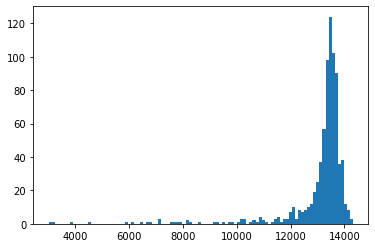

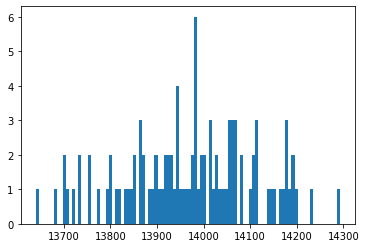

In [16]:
def variation_plotter(df):
    cols = df.loc[:].nunique()
    
    x = cols.sort_values()
    x = dict(x)
    unique_vals = x.values()
    
    plt.hist(unique_vals, bins=100)
    plt.show()
    

for df in exp_dfs:
    variation_plotter(df)

In [17]:
def variance(df):
    
    cols = df.nunique()
    x = cols.sort_values()
    
    return x[-1], x[-1] - x[0]


for df in exp_dfs:
    difference = variance(df)
    print(difference)

(14317, 11318)
(14293, 653)


In [18]:
pipe = Pipeline([('ss', StandardScaler()),('sgd', SGDClassifier(loss='log', max_iter=25000, n_jobs=-1, random_state=34))])

In [19]:
clf = OneVsRestClassifier(pipe, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(train_features, tt_scored, test_size=.25, random_state=20)



In [20]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                              ('sgd',
                                               SGDClassifier(loss='log',
                                                             max_iter=25000,
                                                             n_jobs=-1,
                                                             random_state=34))]),
                    n_jobs=-1)

In [21]:
clf.multilabel_

True

In [22]:
preds = clf.predict(X_test)

In [23]:
preds.shape

(5487, 206)

In [24]:
log_score = log_loss(np.ravel(y_test), np.ravel(preds))

In [25]:
log_score

0.13622199544817404

In [35]:
# chains = [ClassifierChain(pipe, order='random', random_state=i) for i in range(3)]

# for chain in chains:
    # chain.fit(X_train, y_train)

# pred_chains = np.array([chain.predict(X_test) for chain in chains])

In [36]:
# for pred in pred_chains:
    # ll_score = log_loss(y_test, pred)
    # print(ll_score)